# SMAI Assignment - 2

## Question 2: Gaussian Mixture Models

Resources:
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details:
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [104]:
import numpy as np
from scipy.stats import multivariate_normal

class GaussianMixtureModel:
    def __init__(self, n_components, n_features):
        self.n_components = n_components
        self.n_features = n_features
        self.weights = np.ones(n_components) / n_components
        self.means = np.random.rand(n_components, n_features)
        self.covariances = np.array([np.eye(n_features)] * n_components)


    def fit(self, X, max_iter=100, tol=1e-3):
        for _ in range(max_iter):

            responsibilities = self._compute_responsibilities(X)

            self._update_parameters(X, responsibilities)

            if np.abs(np.sum(responsibilities - self.weights)) < tol:
                break

    def _compute_responsibilities(self, X):
        responsibilities = np.zeros((len(X), self.n_components))
        for i in range(len(X)):
            for j in range(self.n_components):
                responsibilities[i, j] = self.weights[j] * multivariate_normal.pdf(X[i], mean=self.means[j], cov=self.covariances[j])
            responsibilities[i] /= np.sum(responsibilities[i])
        return responsibilities

    def _update_parameters(self, X, responsibilities):
        for j in range(self.n_components):
            N_j = np.sum(responsibilities[:, j])
            self.weights[j] = N_j / len(X)
            self.means[j] = np.sum(X * responsibilities[:, j][:, np.newaxis], axis=0) / N_j
            covar_k = np.zeros((self.n_features, self.n_features))
            for i in range(len(X)):
                diff = X[i] - self.means[j]
                covar_k += responsibilities[i, j] * np.outer(diff, diff)
            self.covariances[j] = covar_k / N_j

    def predict(self, X):
        return np.argmax(self._compute_responsibilities(X), axis=1)


### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/My Drive/rollnumber_A2_Q2

/content/drive/My Drive/rollnumber_A2_Q2


In [4]:
!ls

frames	Q2.ipynb  results  videos


#### Extracting Frames from videos

In [5]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'

In [6]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [7]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [8]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

In [9]:
!ls frames/traffic

frame_0001.png	frame_0015.png	frame_0029.png	frame_0043.png	frame_0057.png	frame_0071.png
frame_0002.png	frame_0016.png	frame_0030.png	frame_0044.png	frame_0058.png	frame_0072.png
frame_0003.png	frame_0017.png	frame_0031.png	frame_0045.png	frame_0059.png	frame_0073.png
frame_0004.png	frame_0018.png	frame_0032.png	frame_0046.png	frame_0060.png	frame_0074.png
frame_0005.png	frame_0019.png	frame_0033.png	frame_0047.png	frame_0061.png	frame_0075.png
frame_0006.png	frame_0020.png	frame_0034.png	frame_0048.png	frame_0062.png	frame_0076.png
frame_0007.png	frame_0021.png	frame_0035.png	frame_0049.png	frame_0063.png	frame_0077.png
frame_0008.png	frame_0022.png	frame_0036.png	frame_0050.png	frame_0064.png	frame_0078.png
frame_0009.png	frame_0023.png	frame_0037.png	frame_0051.png	frame_0065.png	frame_0079.png
frame_0010.png	frame_0024.png	frame_0038.png	frame_0052.png	frame_0066.png	frame_0080.png
frame_0011.png	frame_0025.png	frame_0039.png	frame_0053.png	frame_0067.png
frame_0012.png	frame_0026

#### Loading Frames

In [10]:
import glob
import cv2
import numpy as np
frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = np.asarray(img, dtype=np.float64)
    img /= 255.0

    frames.append(img)

frames = np.asarray(frames, dtype=np.float64)

#### Splitting the data

In [78]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return
```

#### Frame Averaging

Extract Background Image from the training data and display it.

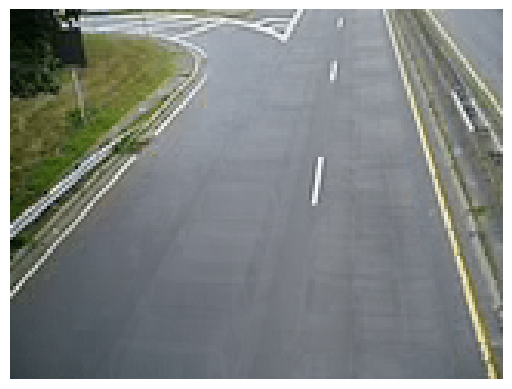

In [105]:
import numpy as np


background_image_avg=np.mean(train_frames, axis=0)
background_image_uint8 = (background_image_avg * 255).astype('uint8')


import matplotlib.pyplot as plt

plt.imshow(background_image_avg)
plt.axis('off')
plt.show()


In [64]:
background_image_avg.shape

(120, 160, 3)

#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

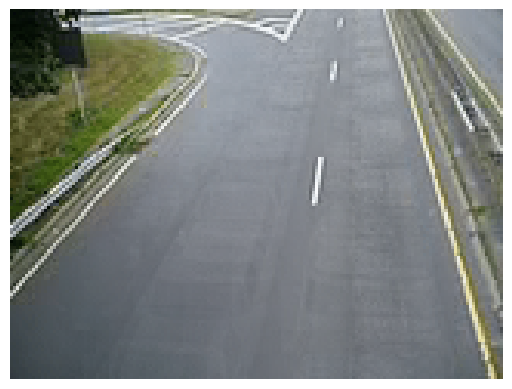

In [103]:
import numpy as np
from scipy.stats import multivariate_normal

class GaussianMixtureModel:
    def __init__(self, n_components, n_features):
        self.n_components = n_components
        self.n_features = n_features
        self.weights = np.ones(n_components) / n_components
        self.means = np.random.rand(n_components, n_features)
        self.covariances = np.array([np.eye(n_features)] * n_components)


    def fit(self, X, max_iter=100, tol=1e-3):
        for _ in range(max_iter):
            responsibilities = self._compute_responsibilities(X)

            self._update_parameters(X, responsibilities)

            if np.abs(np.sum(responsibilities - self.weights)) < tol:
                break

    def _compute_responsibilities(self, X):
        responsibilities = np.zeros((len(X), self.n_components))
        for i in range(len(X)):
            for j in range(self.n_components):
                responsibilities[i, j] = self.weights[j] * multivariate_normal.pdf(X[i], mean=self.means[j], cov=self.covariances[j])
            responsibilities[i] /= np.sum(responsibilities[i])
        return responsibilities

    def _update_parameters(self, X, responsibilities):
        for j in range(self.n_components):
            N_j = np.sum(responsibilities[:, j])
            self.weights[j] = N_j / len(X)
            self.means[j] = np.sum(X * responsibilities[:, j][:, np.newaxis], axis=0) / N_j
            covar_k = np.zeros((self.n_features, self.n_features))
            for i in range(len(X)):
                diff = X[i] - self.means[j]
                covar_k += responsibilities[i, j] * np.outer(diff, diff)
            self.covariances[j] = covar_k / N_j

    def predict(self, X):
        return np.argmax(self._compute_responsibilities(X), axis=1)



def train_and_extract_background(train_frames, n_components=2):
    num_frames, height, width, channels = train_frames.shape
    background_image = np.zeros((height, width, channels))
    pixel_gmms = []

    for i in range(height):
        for j in range(width):
            pixel_series = train_frames[:, i, j, :].reshape(-1, channels)
            gmm = GaussianMixtureModel(n_components=n_components, n_features=channels)  # Pass n_features
            gmm.fit(pixel_series)
            background_index = np.argmax(gmm.weights)
            background_image[i, j] = gmm.means[background_index]
            pixel_gmms.append(gmm)

    return background_image, np.array(pixel_gmms).reshape(height, width)

background_image, pixel_gmms = train_and_extract_background(train_frames)
import matplotlib.pyplot as plt

plt.imshow(background_image)
plt.axis('off')
plt.show()

#### Extract Background Image from the trained model

### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [45]:
# helper functions

def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001

    wait_time = int(1000 // fps)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2.imshow("video", frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break

    cv2.destroyAllWindows()


def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001

    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")

    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2.imshow('frame',frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

        vid_wrt.write(frame)


    vid_wrt.release()
    cv2.destroyAllWindows()

#### GMMs per pixel

In [97]:
def save_frames(frames, fps=10.0, output_path='./results', file_name='foreground'):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    height, width = frames[0].shape[:2]
    out = cv2.VideoWriter(os.path.join(output_path, f'{file_name}.mp4'), fourcc, fps, (width, height))

    for frame in frames:
        if frame.shape[2] == 3:
            frame_bgr = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
        else:
            frame_bgr = (frame * 255).astype(np.uint8)
        out.write(frame_bgr)

    out.release()

In [92]:
def foreground_extraction(test_frames, background_gmm):
    threshold = 0.2
    diff = np.abs(test_frames - background_gmm)
    mask = np.max(diff, axis=-1) > threshold
    foreground_frames = test_frames.copy()
    foreground_frames[~mask] = 0
    return foreground_frames

In [100]:
foreground_frames = foreground_extraction(test_frames, background_image)
save_frames(foreground_frames, fps=10.0, output_path='./results', file_name='backSub_gmm')


#### Frame Averaging

In [106]:
foreground_frames_avg = foreground_extraction(test_frames, background_image_avg)
save_frames(foreground_frames_avg, fps=10.0, output_path='./results', file_name='backSub_frameavg')


In [107]:
background_image_avg.shape

(120, 160, 3)

In [101]:
background_image.shape

(120, 160, 3)